In [37]:
!pip install pycm livelossplot
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['Normalize']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Importing Necessary Modules

In [38]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

from livelossplot import PlotLosses
from pycm import *

import torch
import torch.nn as nn
import torch.nn.functional as F
import csv
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import Dataset 
from torchvision.transforms import Compose, ToTensor, Normalize, RandomRotation, ToPILImage


def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


In [39]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


# Import in Data

In [0]:
X_train_orig = np.load(F"/content/gdrive/My Drive/Colab Notebooks/Mini-Project/acse-module-8-19/kmnist-train-imgs.npy")
y_train_orig = np.load(F"/content/gdrive/My Drive/Colab Notebooks/Mini-Project/acse-module-8-19/kmnist-train-labels.npy")
X_test_orig = np.load(F"/content/gdrive/My Drive/Colab Notebooks/Mini-Project/acse-module-8-19/kmnist-test-imgs.npy")

In [0]:
classmap = {}
with open('/content/gdrive/My Drive/Colab Notebooks/Mini-Project/acse-module-8-19/kmnist_classmap.csv', 'r') as csvfile:
   spamreader = csv.reader(csvfile, delimiter=',')
   next(spamreader)
   for row in spamreader:
       classmap[row[0]] = row[2]

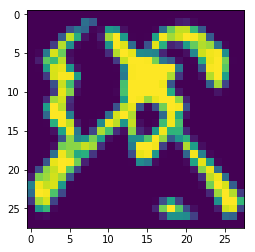

In [42]:
# Image Checking:
plt.imshow(X_train_orig[101])

# Image Augmentation

In [0]:
class CustomImageTensorDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        """
        Args:
            data (Tensor): A tensor containing the data e.g. images
            targets (Tensor): A tensor containing all the labels
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data = data
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample, label = self.data[idx], self.targets[idx]
        sample = sample.view(1, 28, 28).float()/255.
        if self.transform:
            sample = self.transform(sample)

        return sample, label

In [0]:
shuffler = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42).split(X_train_orig, y_train_orig)
indices = [(t, v) for t, v in shuffler][0]

mean = np.mean(X_train_orig)
std = np.std(X_train_orig)
X_train, y_train = X_train_orig[indices[0]], y_train_orig[indices[0]]
X_val, y_val = X_train_orig[indices[1]], y_train_orig[indices[1]]

X_train, y_train = torch.from_numpy(X_train), torch.from_numpy(y_train)
X_val, y_val = torch.from_numpy(X_val), torch.from_numpy(y_val)

Rotation = Compose([
    # Transformation object - Rotate and normalise data
    ToPILImage(),
    RandomRotation(10),
    ToTensor(),
    Normalize(mean=[mean], std=[std]),
])

Normalise = Compose([
    # Transformation object - only normalises data
    Normalize(mean=[mean], std=[std])
])

Gaussian = Compose([
    # Transformation object - Apply gaussian and normalise
    
    Normalize(mean=[mean], std=[std])
])

Rotation_train = CustomImageTensorDataset(X_train, y_train.long(), Rotation)
Original_train = CustomImageTensorDataset(X_train, y_train.long(), Normalise)
Original_val = CustomImageTensorDataset(X_val, y_val.long(), Normalise)


torch.Size([25, 1, 28, 28])
tensor([9, 2, 9, 2, 4, 4, 4, 8, 7, 0, 2, 8, 3, 9, 5, 7, 1, 4, 2, 9, 5, 5, 3, 0,
        1])


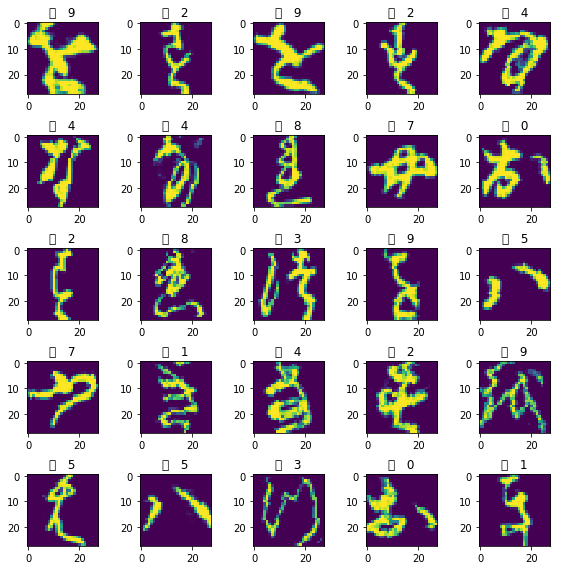

In [45]:
# Make a dataloader to access the PIL images of a batch size of 25:
loader = DataLoader(Rotation_train, batch_size=25, shuffle=True)
# Create an iter object to cycle through dataloader
train_iter = iter(loader)
imgs, labels = train_iter.next()

print(imgs.shape)
print(labels)

# plot our batch of images with label names:
fig, axarr = plt.subplots(5,5,figsize=(8,8))
fig.tight_layout()
for img, label, axs in zip(imgs, labels, axarr.flatten()):
   axs.set_title(classmap[str(label.numpy())] + "   " + str(label.numpy()))
   axs.imshow(img.numpy()[0])

# Modelling:

## Original LeNet5:

In [0]:
class LeNet5(nn.Module):
  def __init__(self):
    super(LeNet5, self).__init__()
    # ***** dont forget *****
    # remove padding since we are using img size of 32 not 28
    self.conv_1 = nn.Conv2d(1, 6, kernel_size=(5,5), stride=(1,1), padding=(2,2))
    self.pool_2 = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
    self.conv_3 = nn.Conv2d(6, 16, kernel_size=(5,5), stride=(1,1))
    self.pool_4 = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
    self.linear_5 = nn.Linear(16*5*5, 120)
    self.linear_6 = nn.Linear(120, 84)
    self.linear_7 = nn.Linear(84, 10) # gaussian connection
    self.act = nn.ReLU()
    
  def forward(self, x):
    debug = False
    
    x = self.act(self.conv_1(x))
    if(debug): print("x1 conv:", x.size())
    x = self.act(self.pool_2(x))
    if(debug): print("x2 pool:", x.size())
    x = self.act(self.conv_3(x))
    if(debug): print("x3 conv:", x.size())
    x = self.act(self.pool_4(x))
    if(debug): print("x4 pool:", x.size())
    x = x.view(-1, x.size(1) * x.size(2) * x.size(3))
    if(debug): print("flatten x4:", x.size())
    x = self.act(self.linear_5(x))
    if(debug): print("x5 linear:", x.size())
    x = self.act(self.linear_6(x))
    if(debug): print("x6 linear:", x.size())
    x = self.linear_7(x)
    
    return x

## Yusuf LeNet5

In [0]:
class LeNet5_Yusuf(nn.Module):
  def __init__(self):
    super(LeNet5_Yusuf, self).__init__()
    self.conv_1 = nn.Conv2d(1, 6, kernel_size=(5,5), stride=(1,1), padding=(2,2))
    self.pool_2 = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
    self.conv_3 = nn.Conv2d(6, 16, kernel_size=(5,5), stride=(1,1))
    self.pool_4 = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
    self.linear_5 = nn.Linear(16*5*5, 120)
    self.linear_6 = nn.Linear(120, 84)
    self.linear_7 = nn.Linear(84, 10)
    self.act = nn.ReLU()
    self.dout = nn.Dropout(p=0.2) #dropout added
    
  def forward(self, x):
    x = self.act(self.conv_1(x))
    x = self.act(self.pool_2(x))
    x = self.act(self.conv_3(x))
    x = self.act(self.pool_4(x))
    x = x.view(-1, x.size(1) * x.size(2) * x.size(3))
    x = self.act(self.linear_5(x))
    x = self.dout(x)
    x = self.act(self.linear_6(x))
    x = self.dout(x) # dropout layer added
    x = self.linear_7(x)
    
    return x

## Train, Validate and Evaluate Functions

In [0]:
def train(model, optimizer, criterion, data_loader):
    model.train()
    train_loss, train_accuracy = 0, 0
    for X, y in data_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        
        # the dimension here was changed to match our KMNIST's dimension
        a2 = model(X.view(-1, 1, 28, 28).float()) 
        
        loss = criterion(a2, y)
        loss.backward()
        train_loss += loss*X.size(0)
        y_pred = F.log_softmax(a2, dim=1).max(1)[1]
        train_accuracy += accuracy_score(y.cpu().numpy(), y_pred.detach().cpu().numpy())*X.size(0)
        optimizer.step()  
        
    return train_loss/len(data_loader.dataset), train_accuracy/len(data_loader.dataset)
  
def validate(model, criterion, data_loader):
    model.eval()
    validation_loss, validation_accuracy = 0., 0.
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            
            # the dimension here was changed to match our KMNIST's dimension
            a2 = model(X.view(-1, 1, 28, 28).float())
            
            loss = criterion(a2, y)
            validation_loss += loss*X.size(0)
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            validation_accuracy += accuracy_score(y.cpu().numpy(), y_pred.cpu().numpy())*X.size(0)
            
    return validation_loss/len(data_loader.dataset), validation_accuracy/len(data_loader.dataset)
  
def evaluate(model, data_loader):
    model.eval()
    ys, y_preds = [], []
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            
            # the dimension here was changed to match our KMNIST's dimension
            a2 = model(X.view(-1, 1, 28, 28).float())
            
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            ys.append(y.cpu().numpy())
            y_preds.append(y_pred.cpu().numpy())
            
    return np.concatenate(y_preds, 0),  np.concatenate(ys, 0)

# Training Models

In [0]:
seed = 42
lr = 1e-2
momentum = 0.5
batch_size = 64
test_batch_size = 1000
n_epochs = 30

weight_decay = [1e-3, 1e-4, 1e-5, 0.0]

In [0]:
def train_model(weight_decay, model, train_loader, validate_loader):
  set_seed(seed)
  model = model.to(device)
  optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum)
  criterion = nn.CrossEntropyLoss()
  
  liveloss = PlotLosses()
  for epoch in range(n_epochs):
      logs = {}
      train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)
      logs['' + 'log loss'] = train_loss.item()
      logs['' + 'accuracy'] = train_accuracy.item()

      validation_loss, validation_accuracy = validate(model, criterion, validate_loader)
      logs['val_' + 'log loss'] = validation_loss.item()
      logs['val_' + 'accuracy'] = validation_accuracy.item()

      liveloss.update(logs)
      liveloss.draw()

  return liveloss, validation_loss, validation_accuracy

# KFOLD Validation

In [0]:
from sklearn.model_selection import StratifiedKFold

def normalize(X, mean, std):
  """Normalize every channel of the X data"""
  X -= mean
  X /= std
  return X

In [0]:
def kfold_datasets(n_splits, X_train_orig, y_train_orig, verbatim=False):
  '''Wrapper function that returns a list of train/val datasets which have been 
     subjected to the KFold method. 
  '''
  
  kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

  fold_train_loader = [] # list of shuffled training dataloaders
  fold_validation_loader = [] # list of shuffled validation dataloaders

  for train_index, test_index in kf.split(X_train_orig, y_train_orig):
    if verbatim: print("TRAIN:", train_index, "Validation:", test_index)
    X_train, X_val = X_train_orig[train_index], X_train_orig[test_index]
    y_train, y_val = y_train_orig[train_index], y_train_orig[test_index]

    if verbatim: print("train size:", X_train.shape, "test size:", X_val.shape)

    X_train, y_train = torch.from_numpy(X_train).float(), torch.from_numpy(y_train)
    X_val, y_val = torch.from_numpy(X_val).float(), torch.from_numpy(y_val)

    mean = torch.mean(X_train)
    std = torch.std(X_train)

    train_dataset = TensorDataset(normalize(X_train, mean, std), y_train.long())
    validation_dataset = TensorDataset(normalize(X_val, mean, std), y_val.long())

    #train_dataset = CustomImageTensorDataset(X_train, y_train.long(), Normalise)
    #validation_dataset = CustomImageTensorDataset(X_val, y_val.long(), Normalise)

    # initialize the data-loaders
    fold_train_loader.append(DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4))
    fold_validation_loader.append(DataLoader(validation_dataset, batch_size=test_batch_size, shuffle=False, num_workers=0))
    
    return fold_train_loader, fold_validation_loader

In [0]:
def train_model_kfold(weight_decay, fold_train_loader, fold_validation_loader):
  """ function to easily train the model with weight_decay as input parameter."""
  
  fold_liveloss = []
  fold_loss = 0.
  fold_acc = 0.
  for fold in range(len(fold_train_loader)):
    # CHANGE THE MODEL HERE:
    model = LeNet5_Yusuf()
    liveloss, val_loss, val_acc = train_model(weight_decay, model, fold_train_loader[fold], fold_validation_loader[fold])
    fold_liveloss.append(liveloss)
    fold_loss += val_loss
    fold_acc += val_acc
    print("fold:", fold)
  print("Averaged Accuracy: ", (fold_acc/len(fold_train_loader))*100)
  return fold_liveloss, fold_loss, fold_acc

In [0]:
fold_train_loader, fold_validation_loader = kfold_datasets(5, X_train_orig, y_train_orig, False)
lloss, loss, acc = train_model_kfold(weight_decay[3], fold_train_loader, fold_validation_loader)

## HYPER PARAMETER VALIDATION

## PRELIM FULL TRAINING

### ~ ~ ~ 90% TRAIN -> TRAIN SET
### ~ ~ ~ 10% TRAIN -> TEST SET

Because we do not have the actual test set labels to evaluate our model on. We will create our own test set out of the given train set so we have a rough idea of our model prediction.

In [0]:
shuffler = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42).split(X_train_orig, y_train_orig)
indices = [(t, v) for t, v in shuffler][0]

X_train = X_train_orig[indices[0]]
mean = np.mean(X_train)
std = np.std(X_train)

X_train, y_train = normalize(X_train_orig[indices[0]].astype(float), mean, std), y_train_orig[indices[0]]
X_test, y_test = normalize(X_train_orig[indices[1]].astype(float), mean, std), y_train_orig[indices[1]]

X_train, y_train = torch.from_numpy(X_train), torch.from_numpy(y_train)
X_test, y_test = torch.from_numpy(X_test), torch.from_numpy(y_test)

X_train = X_train.view(X_train.size(0), 1, X_train.size(1), X_train.size(2))
X_test = X_test.view(X_test.size(0), 1, X_test.size(1), X_test.size(2))

# Assemble tensor datasets
train_full_ds = TensorDataset(X_train, y_train.long())
test_full_ds = TensorDataset(X_test, y_test.long())

# Assemble dataloaders
train_loader_full = DataLoader(train_full_ds, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader_full = DataLoader(test_full_ds, batch_size=test_batch_size, shuffle=False, num_workers=0)

# Create new LeNet5 model for training
set_seed(seed)
model = LeNet5_Yusuf().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=0.0)
criterion = nn.CrossEntropyLoss()

# Train the model
liveloss = PlotLosses()
for epoch in range(n_epochs):
    logs = {}
    train_loss, train_accuracy = train(model, optimizer, criterion, train_loader_full)

    logs['' + 'log loss'] = train_loss.item()
    logs['' + 'accuracy'] = train_accuracy.item()

    logs['val_' + 'log loss'] = 0.
    logs['val_' + 'accuracy'] = 0.

    liveloss.update(logs)
    liveloss.draw()


In [0]:
test_loss, test_accuracy = validate(model, criterion, test_loader_full)    
print("Avg. Test Loss: %1.3f" % test_loss.item(), " Avg. Test Accuracy: %1.3f" % test_accuracy.item())
print("")

Avg. Test Loss: 0.067  Avg. Test Accuracy: 0.983



## Final Full Training
### Actual Test Predictions

Here we train the model onto the full training set and use the given test dataset for the Kaggle competition.

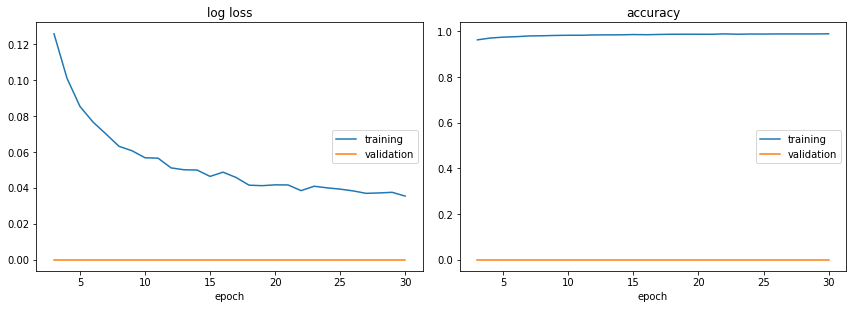

log loss:
training   (min:    0.035, max:    0.586, cur:    0.035)
validation (min:    0.000, max:    0.000, cur:    0.000)

accuracy:
training   (min:    0.811, max:    0.989, cur:    0.989)
validation (min:    0.000, max:    0.000, cur:    0.000)


In [0]:
# Set the mean std of the full train set
X_train = X_train_orig
mean = np.mean(X_train)
std = np.std(X_train)

# normlaise the train and test sets
X_train, y_train = normalize(X_train_orig.astype(float), mean, std), y_train_orig
X_test = normalize(X_test_orig.astype(float), mean, std)
y_test = torch.from_numpy(np.array(range(X_test.shape[0]))).float() # dummy y test set!

# convert sets into torch
X_train, y_train = torch.from_numpy(X_train), torch.from_numpy(y_train)
X_test = torch.from_numpy(X_test)

# resize sets to the correct shape
X_train = X_train.view(X_train.size(0), 1, X_train.size(1), X_train.size(2))
X_test = X_test.view(X_test.size(0), 1, X_test.size(1), X_test.size(2))

# Assemble tensor datasets
train_full_ds = TensorDataset(X_train, y_train.long())
test_full_ds = TensorDataset(X_test, y_test.long())

# Assemble dataloaders
train_loader_full = DataLoader(train_full_ds, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader_full = DataLoader(test_full_ds, batch_size=test_batch_size, shuffle=False, num_workers=0)

# Create new LeNet5 model for training
set_seed(seed)
model = LeNet5_Yusuf().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=0.001)
criterion = nn.CrossEntropyLoss()

# Train the model
liveloss = PlotLosses()
for epoch in range(n_epochs):
    logs = {}
    train_loss, train_accuracy = train(model, optimizer, criterion, train_loader_full)

    logs['' + 'log loss'] = train_loss.item()
    logs['' + 'accuracy'] = train_accuracy.item()

    logs['val_' + 'log loss'] = 0.
    logs['val_' + 'accuracy'] = 0.

    liveloss.update(logs)
    liveloss.draw()
    
y_predictions, _ = evaluate(model, test_loader_full)

In [0]:
y_predictions = [int(y) for y in y_predictions]
print(len(y_predictions))
print(y_predictions)

10000
[2, 9, 3, 8, 3, 3, 8, 3, 2, 5, 6, 3, 3, 3, 1, 5, 4, 8, 6, 3, 7, 5, 7, 5, 7, 0, 3, 5, 4, 4, 6, 8, 5, 9, 5, 6, 6, 3, 0, 6, 4, 7, 8, 1, 1, 6, 9, 0, 1, 0, 1, 1, 4, 8, 4, 1, 3, 3, 3, 4, 6, 4, 8, 3, 6, 5, 3, 4, 6, 1, 5, 9, 9, 7, 3, 2, 3, 7, 6, 3, 4, 1, 1, 5, 9, 1, 5, 1, 0, 1, 2, 7, 1, 6, 7, 3, 6, 5, 5, 2, 0, 8, 8, 2, 3, 5, 9, 1, 0, 8, 5, 2, 0, 4, 6, 5, 2, 9, 0, 9, 3, 6, 9, 5, 6, 2, 0, 7, 6, 2, 9, 0, 4, 1, 3, 4, 6, 9, 9, 5, 1, 4, 5, 9, 6, 8, 2, 4, 7, 3, 5, 1, 8, 5, 8, 6, 3, 2, 7, 6, 2, 5, 6, 7, 5, 2, 8, 0, 6, 6, 4, 1, 9, 2, 8, 6, 5, 6, 8, 7, 8, 4, 0, 6, 5, 7, 2, 6, 2, 1, 8, 9, 0, 7, 4, 3, 0, 1, 6, 3, 1, 3, 5, 0, 8, 8, 5, 8, 2, 2, 3, 2, 9, 5, 7, 5, 4, 5, 4, 7, 2, 3, 7, 8, 5, 9, 0, 7, 5, 0, 1, 6, 6, 3, 0, 9, 8, 4, 9, 0, 2, 0, 3, 0, 7, 6, 8, 3, 7, 9, 4, 4, 0, 5, 2, 9, 6, 4, 0, 4, 2, 7, 3, 2, 6, 7, 0, 9, 1, 5, 4, 5, 5, 9, 8, 7, 9, 0, 3, 3, 6, 1, 6, 8, 7, 7, 9, 2, 6, 2, 2, 7, 5, 7, 3, 8, 0, 8, 3, 0, 3, 2, 8, 7, 9, 2, 0, 2, 1, 0, 0, 7, 8, 7, 9, 4, 2, 2, 9, 8, 6, 6, 8, 4, 9, 7, 6, 3, 5, 2, 2, 

In [0]:
model_save_name = "MINI-submit1-101"
path = F"/content/gdrive/My Drive/Colab Notebooks/Mini-Project/Model/{model_save_name}" 
torch.save(model.state_dict(), path)

output_save_name = "Yusuf_model_test_output.txt"
path_out = F"/content/gdrive/My Drive/Colab Notebooks/Mini-Project/{output_save_name}"
np.savetxt(path_out, np_test_out, fmt='%d')